In [349]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import optimizers



# Getting useful info from the dataset

In [352]:
# input_directory = r"D:\CODE\Machine Learning\sketchheads\images"
# output_directory = r"D:\CODE\Machine Learning\sketchheads\trimmed_images"
# os.makedirs(output_directory, exist_ok=True)

# # Process each NDJSON file
# for file in os.listdir(input_directory):
#     if file.endswith(".ndjson"):
#         input_file_path = os.path.join(input_directory, file)  # Full input path
#         output_file_path = os.path.join(output_directory, file)  # Full output path

#         # Read the NDJSON file into a DataFrame
#         df = pd.read_json(input_file_path, lines=True).head(30000)
#         # Keep only 'word' and 'drawing' columns
#         df = df[['word', 'recognized', 'drawing']]

#         # Write the modified data back to NDJSON format
#         with open(output_file_path, "w") as outfile:
#             for record in df.to_dict(orient="records"):
#                 json.dump(record, outfile)
#                 outfile.write("\n")  # Ensure newline after each JSON object

#         print(f"Processed {file} - saved to {output_file_path}")

# print("All files modified successfully!")

# Loading the stroke and Word data

In [356]:
image_directory = r"D:\CODE\Machine Learning\sketchheads\trimmed_images"
all_data = {}

for file in os.listdir(image_directory):
    if file.endswith(".ndjson"): 
        file_path = os.path.join(image_directory, file)  
        print(f"Processing: {file_path}")
        
        df = pd.read_json(file_path, lines=True)
        df = df[df['recognized'] == True]
        
        all_data[file[:-7]] = df.head(5000)[['word', 'drawing']]
        # print(f"The length of {file[:-7]} is {len(all_data[file[:-7]])}" )


df = pd.concat(all_data.values(), keys=all_data.keys()).reset_index(level=0).rename(columns={'index': 'category'})
df = df[['word','drawing']]
print(len(df))


Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\ant.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\bear.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\bee.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\bird.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\butterfly.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\camel.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\cat.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\crab.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\crocodile.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\dog.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\dolphin.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\fish.ndjson
Processing: D:\CODE\Machine Learning\sketchheads\trimmed_images\frog.ndjson
Pr

# Constants


In [358]:

# Define image size
IMG_SIZE = 64
thicc = 2

In [359]:

# Scale strokes to fit in the image_size range
def normalize(val, min_val, max_val, target_size):
    return int((val - min_val) / (max_val - min_val) * (target_size - 1))

def stroke_image(strokes, img_size = IMG_SIZE, thicc = 2):
    canvas = np.ones((img_size, img_size), dtype=np.uint8) * 255
    
    # Get min/max values to normalize strokes
    all_x = [x for stroke in strokes for x in stroke[0]]
    all_y = [y for stroke in strokes for y in stroke[1]]

    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)

    for stroke in strokes:
        x_points = [normalize(x, min_x, max_x, img_size) for x in stroke[0]]
        y_points = [normalize(y, min_y, max_y, img_size) for y in stroke[1]]

        # Draw the strokes as lines
        for i in range(len(x_points) - 1):
            cv2.line(canvas, (x_points[i], y_points[i]), (x_points[i+1], y_points[i+1]), 0, thickness=thicc)
    
    return canvas


In [360]:
# Convert all sketches to images
X_images = np.zeros((len(df), IMG_SIZE, IMG_SIZE), dtype=np.uint8)

for i, strokes in tqdm(enumerate(df["drawing"]), total=len(df)):
    X_images[i] = stroke_image(strokes , IMG_SIZE , thicc= thicc)  # Convert string to list if needed

# Reshape for CNN (adding a channel dimension)
X_images = X_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype(np.float32) / 255.0  # Normalize to [0,1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["word"])  # Converts labels into numerical format

# y_encoded = df['word']

# Convert to NumPy array
y_encoded = np.array(y_encoded)

print("X shape:", X_images.shape)  # Should be (num_samples, 256, 256, 1)
print("y shape:", y_encoded.shape)  # Should be (num_samples,)
# Print unique class mappings
print("Class Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

100%|████████████████████████████████████████████████████████████████████████| 120000/120000 [00:15<00:00, 7594.67it/s]


X shape: (120000, 64, 64, 1)
y shape: (120000,)
Class Mapping: {'ant': 0, 'bear': 1, 'bee': 2, 'bird': 3, 'butterfly': 4, 'camel': 5, 'cat': 6, 'crab': 7, 'crocodile': 8, 'dog': 9, 'dolphin': 10, 'fish': 11, 'frog': 12, 'giraffe': 13, 'horse': 14, 'kangaroo': 15, 'lion': 16, 'octopus': 17, 'panda': 18, 'penguin': 19, 'sea turtle': 20, 'shark': 21, 'snail': 22, 'tiger': 23}


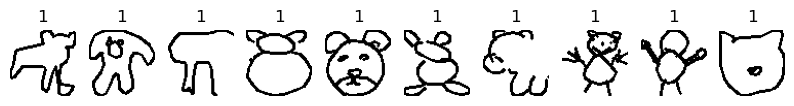

In [361]:
num_images = 10
fig, axes = plt.subplots(1, num_images, figsize=(10, 2))

for i in range(10):
    axes[i].imshow(X_images[i+6000].squeeze(), cmap="gray")
    axes[i].set_title(y_encoded[i +6000])  # Assuming y contains labels
    axes[i].axis("off")

plt.show()

In [362]:
X_train , X_test , y_train, y_test = train_test_split(X_images, y_encoded, train_size=0.9 , random_state= 27, stratify= y_encoded)

X_train , X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.9 , random_state= 13, stratify= y_train)


In [363]:
X_train.shape , y_train.shape

((97200, 64, 64, 1), (97200,))

In [364]:
X_test.shape , y_test.shape

((12000, 64, 64, 1), (12000,))

In [365]:
X_valid.shape , y_valid.shape

((10800, 64, 64, 1), (10800,))

In [366]:
from tensorflow.keras.utils import to_categorical

num_classes = len(label_encoder.classes_)  # Get the number of categories

# One-hot encode labels
y_train_onehot = to_categorical(y_train, num_classes=num_classes)
y_valid_onehot = to_categorical(y_valid, num_classes=num_classes)
y_test_onehot = to_categorical(y_test , num_classes=num_classes)

# Print new shape
print("y_train shape:", y_train_onehot.shape)  # Should be (19440, num_classes)
print("y_valid shape:", y_valid_onehot.shape)
print("y_test shape:", y_test_onehot.shape)

y_train shape: (97200, 24)
y_valid shape: (10800, 24)
y_test shape: (12000, 24)


# Model architecture


In [368]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1) )) # A 3x3 kernel is being used to get 32 feature maps
model.add(layers.BatchNormalization()) # Batch normalization so that the values after Conv dont get too crazy 
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2,2))) # Converts each 62x62 feature map to a 31x31 to get a total of (32x32x32)


model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.BatchNormalization()) 
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2,2))) # Converts each 29x29 feature map to a 16x16 to get a total of (16x16x64)


model.add(layers.Conv2D(128, (3, 3), padding='same')) 
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2,2))) 


# Conv Block 4 (padding='same')
model.add(layers.Conv2D(256, (3,3), padding='same')) 
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(128 , kernel_regularizer=regularizers.l2(0.001))) # ✅ L2 Regularization
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))  # Prevents overfitting
model.add(layers.Dense(24, activation='softmax'))  # 24 classes

C:\Users\Admin\Anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [369]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Use sparse if labels are integers
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall'),
                    tf.keras.metrics.AUC(name='auc') ])

In [370]:
# Model Summary
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_87 (Conv2D)                   │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_29 (ReLU)                      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_86 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_30 (ReLU)                      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_87 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_31 (ReLU)                      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_88 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_90 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_68               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_32 (ReLU)                      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_89 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_33 (ReLU)                      │ (None, 128)                 │              

 Total params: 425,752 (1.62 MB)

 Trainable params: 424,792 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [384]:
# Train the model
history = model.fit(
    X_train,y_train_onehot,  # Training dataset
    validation_data=(X_valid,y_valid_onehot),  # Validation dataset
    epochs=30,  # Adjust based on performance
    batch_size=32,  # Standard batch size, can be tuned
)

Epoch 1/30
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 328s 107ms/step - accuracy: 0.3545 - auc: 0.8601 - loss: 2.2589 - precision: 0.7205 - recall: 0.1396 - val_accuracy: 0.5135 - val_auc: 0.9349 - val_loss: 1.6443 - val_precision: 0.7630 - val_recall: 0.3566
Epoch 2/30
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 330s 109ms/step - accuracy: 0.5938 - auc: 0.9538 - loss: 1.4119 - precision: 0.8006 - recall: 0.4147 - val_accuracy: 0.6322 - val_auc: 0.9653 - val_loss: 1.2383 - val_precision: 0.7987 - val_recall: 0.5109
Epoch 3/30
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 334s 110ms/step - accuracy: 0.6429 - auc: 0.9643 - loss: 1.2442 - precision: 0.8222 - recall: 0.4947 - val_accuracy: 0.7390 - val_auc: 0.9808 - val_loss: 0.9567 - val_precision: 0.8942 - val_recall: 0.5946
Epoch 4/30
3038/3038 ━━━━━━━━━━━━━━━━━━━━ 335s 110ms/step - accuracy: 0.6765 - auc: 0.9695 - loss: 1.1412 - precision: 0.8366 - recall: 0.5402 - val_accuracy: 0.7688 - val_auc: 0.9862 - val_loss: 0.8290 - val_precision: 0.8854 - val_recall: 0.6561
Epoch 5/

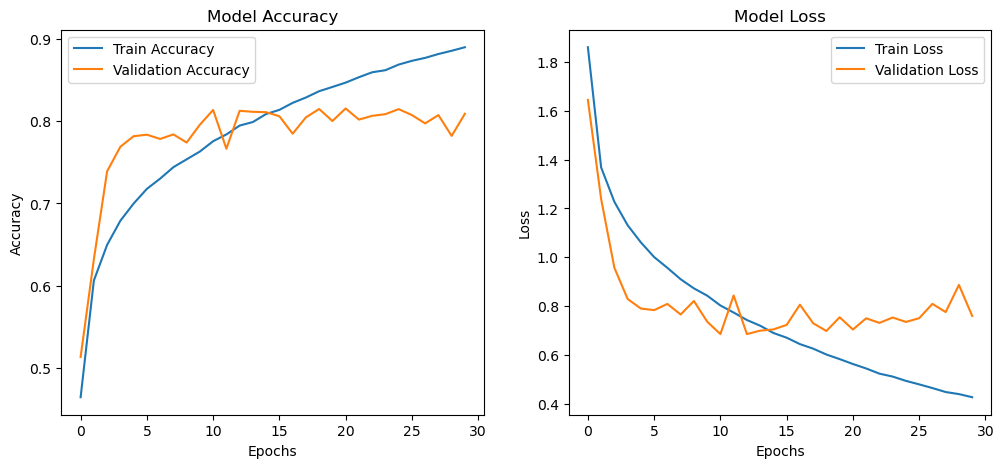

In [385]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Plot Loss
    axs[1].plot(history.history['loss'], label='Train Loss')
    axs[1].plot(history.history['val_loss'], label='Validation Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.show()

# Call the function after training
plot_training_history(history)


In [386]:
# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred_probs, axis=1)
print(y_pred_classes)

375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
[13 15  0 ... 12  6  5]


In [387]:
print(y_test)

[13 15  0 ... 12  6  7]


In [388]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


Accuracy: 0.8040
Classification Report:
              precision    recall  f1-score   support

         ant       0.80      0.93      0.86       500
        bear       0.63      0.54      0.58       500
         bee       0.86      0.88      0.87       500
        bird       0.74      0.80      0.77       500
   butterfly       0.99      0.91      0.95       500
       camel       0.88      0.91      0.89       500
         cat       0.83      0.80      0.81       500
        crab       0.91      0.84      0.87       500
   crocodile       0.58      0.87      0.70       500
         dog       0.53      0.49      0.51       500
     dolphin       0.82      0.72      0.76       500
        fish       0.97      0.86      0.91       500
        frog       0.64      0.55      0.59       500
     giraffe       0.86      0.89      0.87       500
       horse       0.83      0.71      0.77       500
    kangaroo       0.76      0.91      0.83       500
        lion       0.95      0.89      0.

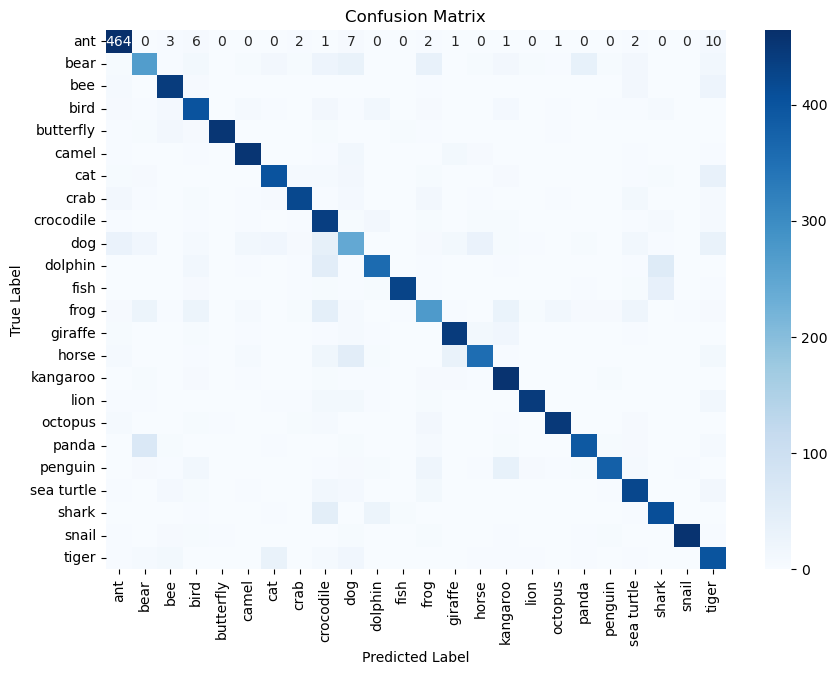

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [390]:
model.save("CNN_30ep_32bsize_5000item.h5")


In [398]:
model.save('CNN_30ep_32bsize_5000item.keras')

In [18]:
!pip install --user ipycanvas

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from ipycanvas import Canvas
from ipywidgets import Button, VBox
from PIL import Image

# Load the trained CNN model
model = tf.keras.models.load_model("CNN_30ep_32bsize_5000item.keras")

# Class mapping (Ensure this matches your training labels)
class_mapping = {
    0: 'ant', 1: 'bear', 2: 'bee', 3: 'bird', 4: 'butterfly', 5: 'camel',
    6: 'cat', 7: 'crab', 8: 'crocodile', 9: 'dog', 10: 'dolphin', 11: 'fish',
    12: 'frog', 13: 'giraffe', 14: 'horse', 15: 'kangaroo', 16: 'lion',
    17: 'octopus', 18: 'panda', 19: 'penguin', 20: 'sea turtle',
    21: 'shark', 22: 'snail', 23: 'tiger'
}

# Create a drawing canvas
canvas = Canvas(width=256, height=256, line_width=8)

# Function to preprocess the drawn image
def preprocess_canvas():
    # Get the raw pixel data
    img = np.array(canvas.to_image())  # Get as RGBA (256, 256, 4)
    img = img[:, :, 3]  # Extract only alpha channel (black & white)
    
    # Resize to 64x64 and normalize
    img = Image.fromarray(img).resize((64, 64)).convert("L")  # Grayscale
    img = np.array(img, dtype=np.float32) / 255.0  # Normalize to [0,1]
    img = img.reshape(1, 64, 64, 1)  # Add batch dimension
    return img

# Function to make a prediction
def predict():
    img = preprocess_canvas()
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)  # Get the highest probability class
    predicted_animal = class_mapping[predicted_class]  # Map to animal name
    
    # Display result
    print(f"🎯 Predicted Animal: {predicted_animal}")

# Create a 'Guess' button
guess_button = Button(description="Guess")
guess_button.on_click(lambda _: predict())

# Create a 'Clear' button
clear_button = Button(description="Clear")
clear_button.on_click(lambda _: canvas.clear())

# Display UI
VBox([canvas, guess_button, clear_button])


ModuleNotFoundError: No module named 'ipycanvas'

In [16]:
import sys
print(sys.executable)


C:\Users\Admin\Anaconda3\python.exe
